**Лабораторная работа 2**

**Выполнил Кирилл Запорожченко, ФЗ-11**

# Отображатель графиков обучения

In [2]:
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output
from tensorflow.keras import backend as K


class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.inter_dim = []
        self.val_inter_dim = []
        self.logits = []
        self.val_logits = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1
        f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

        clear_output(wait=True)

        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss:" +
                 str(round(logs.get('loss'), 2)))
        ax1.plot(self.x, self.val_losses, label="v_loss:" +
                 str(round(logs.get('val_loss'), 2)))
        ax1.legend()

        ax2.plot(self.x, self.acc, label="acc:" +
                 str(round(logs.get('accuracy'), 2)))
        ax2.plot(self.x, self.val_acc, label="v_acc:" +
                 str(round(logs.get('val_accuracy'), 2)))
        ax2.legend()

        plt.savefig("fig")
        plt.show()


plot = PlotLearning()



# Загружаем и исследуем датасет

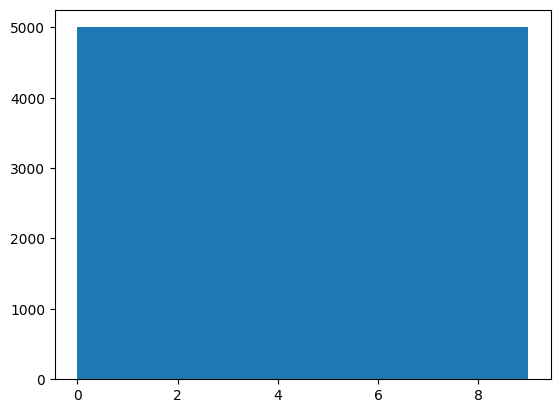

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
from __future__ import print_function
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
import os
import tensorflow.keras as keras
import numpy as np

num_classes = 10

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_cnn_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

plt.hist(y_train, num_classes)
plt.show()

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train /= 255
x_test /= 255

# Создание и обучение модели
Создаем и обучаем сверточную сеть

#### Вариант 1

In [8]:
from warnings import filterwarnings
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, ReLU, PReLU, InputLayer
from tensorflow.keras import regularizers

model = Sequential()

# Добавление регуляризации Weight Decay к сверточным слоям
weight_decay = 0.0001  # Гиперпараметр

model.add(Conv2D(16, (3, 3), input_shape=(32, 32, 3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())

model.add(AveragePooling2D(2, 2))

start_filter = 16
layer_count = 30
filter_list = [(start_filter * i) if i < 4 else 128 for i in range(1, layer_count + 1)]

for i in range(len(filter_list)):
    model.add(Conv2D(filter_list[i], (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

model.add(AveragePooling2D(2, 2))
model.add(Flatten())

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Инициализируем оптимизатор
opt = keras.optimizers.Adam(0.001)

# Обучаем модель с помощью RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 batch_normalization_11 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 re_lu_11 (ReLU)             (None, 32, 32, 16)        0         
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 16)        2320      
                                                                 
 batch_normalization_12 (Bat  (None, 16, 16, 16)      

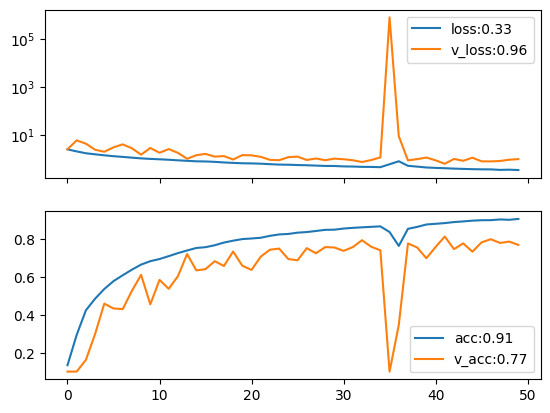

98/98 [==============================] - 55s 544ms/step - loss: 0.3350 - accuracy: 0.9080 - val_loss: 0.9555 - val_accuracy: 0.7704


In [9]:
batch_size = 512
epochs = 50


print('Using data augmentation.')
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=100, callbacks=[plot])


#### Вариант 2 - лучший вариант, используется дальше в коде

In [4]:
from warnings import filterwarnings
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, ReLU, PReLU, InputLayer
from tensorflow.keras import regularizers

model = Sequential()

# Добавление регуляризации Weight Decay к сверточным слоям
weight_decay = 0.0001  # Гиперпараметр

model.add(Conv2D(16, (3, 3), input_shape=(32, 32, 3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())

model.add(MaxPooling2D(2,2))

start_filter = 16
layer_count = 30

for i in range(layer_count):
    if start_filter < 128:
        start_filter *= 2
    model.add(Conv2D(start_filter, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

model.add(AveragePooling2D(2, 2))
model.add(Flatten())

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Инициализируем оптимизатор
opt = keras.optimizers.Nadam(0.001)

# Обучаем модель с помощью RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       1

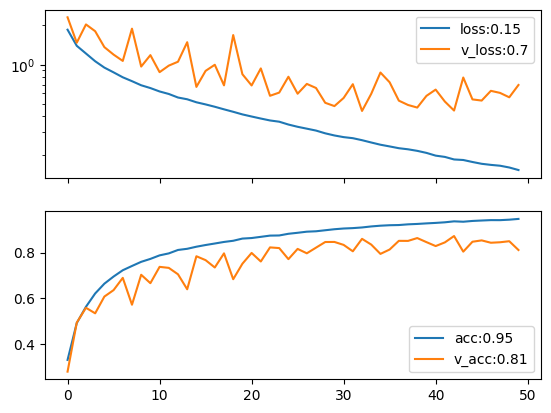

391/391 [==============================] - 79s 202ms/step - loss: 0.1538 - accuracy: 0.9480 - val_loss: 0.6954 - val_accuracy: 0.8116


In [7]:
batch_size = 128
epochs = 50


print('Using data augmentation.')
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=50, callbacks=[plot])


Благодаря внесенным изменениям в изначальную модель, удалось достигнусть **v_acc = 0.81**

# Отображение результата
Отобразим результат распознавания 10 случайных тестовых изображений

          GT class           Predicted class
1/1 [==============================] - 1s 563ms/step


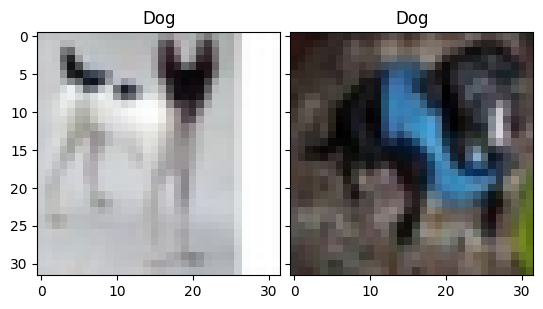

1/1 [==============================] - 0s 0s/step


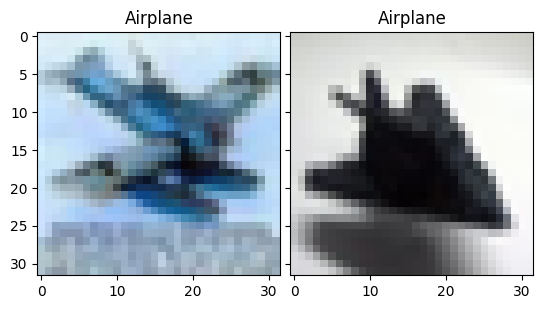

1/1 [==============================] - 0s 17ms/step


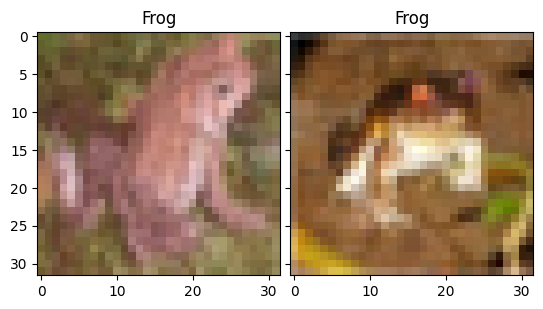

1/1 [==============================] - 0s 0s/step


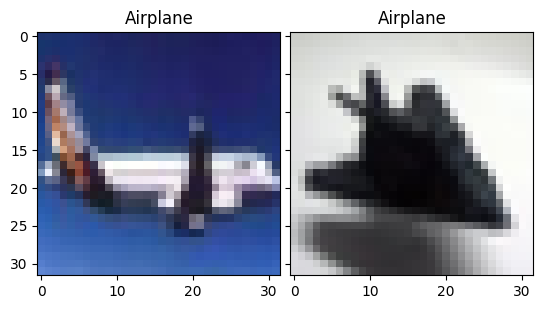

1/1 [==============================] - 0s 17ms/step


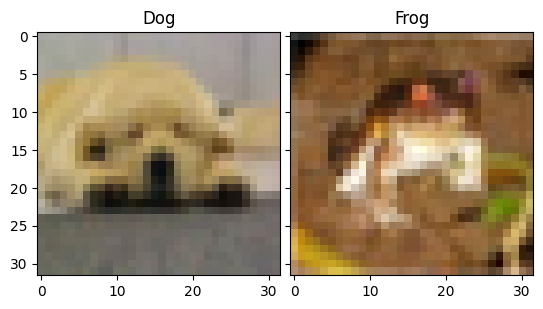

1/1 [==============================] - 0s 16ms/step


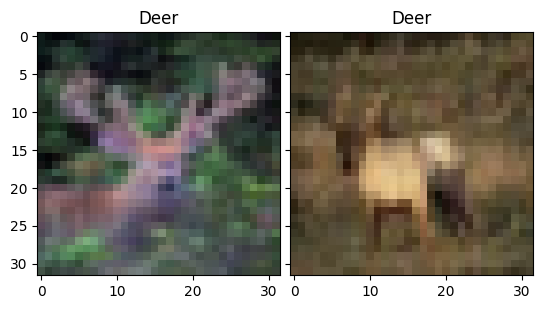

1/1 [==============================] - 0s 14ms/step


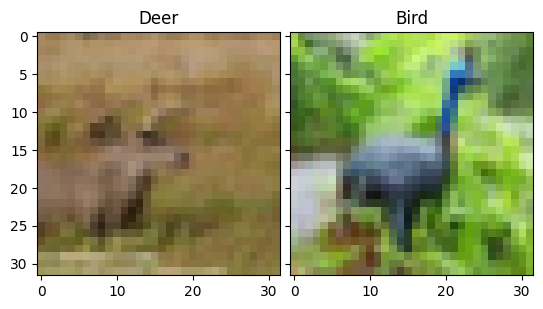

1/1 [==============================] - 0s 669us/step


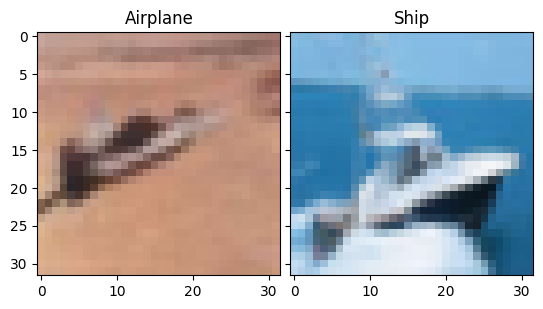

1/1 [==============================] - 0s 26ms/step


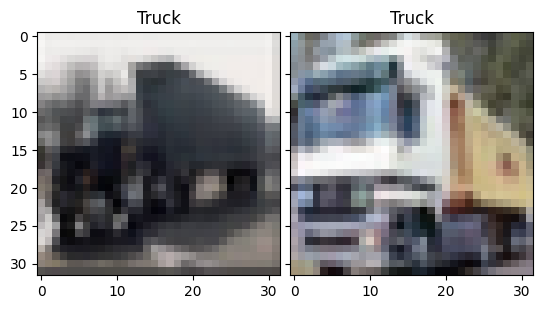

1/1 [==============================] - 0s 18ms/step


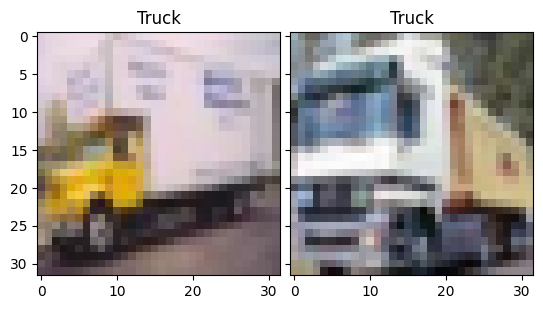

In [8]:
from matplotlib.colors import Colormap
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

class_list = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def get_class_sample(cls_index):
    for i in range(len(y_train)):
        if np.argmax(y_train[i]) == cls_index:
            return x_train[i]
    return None

print("          GT class           Predicted class")

for i in range(10):
    plt.set_cmap(Colormap("Greys"))
    fig = plt.figure(1, (4., 4.))
    grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.1,
                 )

    images = []
    np_images = []
    k = random.randint(0,len(x_test)-1)
    images.append(np.expand_dims(x_test[k], axis=0))
    np_images = np.vstack(images)
    y = model.predict(np_images)

    c = np.argmax(y[0])

    cls_name_pred = c
    cls_name_gt = np.argmax(y_test[k])

    img = x_test[k]
    img_pred = get_class_sample(cls_name_pred)
    grid[0].imshow(np.reshape(img,(32,32,3)))
    grid[0].set_title("{}".format(class_list[cls_name_gt]))
    grid[1].imshow(np.reshape(img_pred,(32,32,3)))
    grid[1].set_title("{}".format(class_list[cls_name_pred]))

    plt.show()



1/1 [==============================] - 0s 16ms/step


<Axes: >

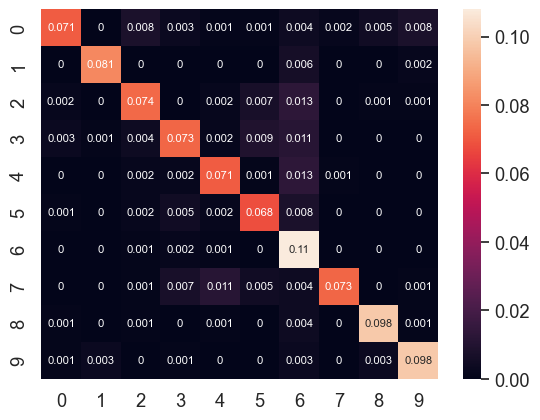

In [11]:
import pandas as pd
import seaborn as sn

def get_conf_matrix(x_test, y_test):
    m = np.zeros((10,10))
    acc = 0
    i = 0
    for x in x_test:
        yp = np.argmax(model.predict(np.expand_dims(x, axis=0)))
        m[np.argmax(y_test[i]),yp] += 1
        i = i+1
    m = m/len(y_test)

    return m

m = get_conf_matrix(x_test[:1000], y_test[:1000])
df_cm = pd.DataFrame(m, range(10), range(10))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8})

Загрузим и классифицируем произвольное изображение

In [14]:
%pwd

'c:\\Users\\Kreal\\Documents\\NN\\LR2'

(1500, 2100, 3)
1/1 [==============================] - 0s 2ms/step
6.898208e-06 Airplane
0.0030251367 Car
3.2633159e-06 Bird
9.1467024e-07 Cat
1.5380047e-07 Deer
6.3941866e-06 Dog
7.78446e-06 Frog
6.4964576e-07 Horse
0.00010729208 Ship
0.99684155 Truck


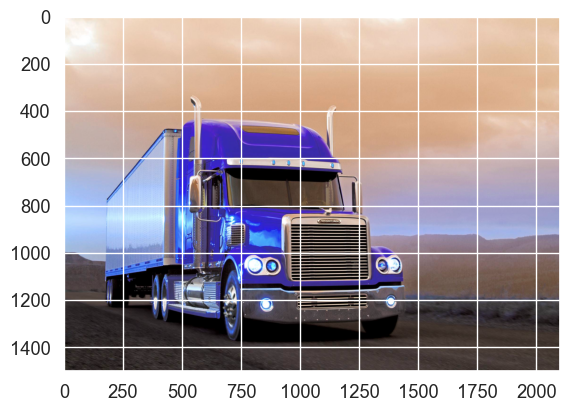

In [15]:
import cv2


img = cv2.imread("truck.jpg")
print(img.shape)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img = img[...,::-1]
img = cv2.resize(img,(32,32))
img = img.astype("float32")/255
y = model.predict(np.expand_dims(img,0))

for i, j in enumerate(y[0]):
  print(j, class_list[i])

**Выводы по выполнению лаборабораторной работы**

В ходе выполнения лабораторной работы протестировано несколько вариантов модели нейронной сети. Пробовались различное количество слоев, различные регулировщики и т. п. Дабы не перегружать блокнот, в него вошли только последние 2 варианта модели нейросети. Вариант 2 оказался самым лучшим, он позволил обучить модель с результирующим показателем v_acc = 0.81. Улучшение модели позволило увеличить процент уверенности в распозновании грузовика на произвольном изображением с 93% до почти что 100%